# Practical 1 - Motion Estimation

## Setup

### Import necessay libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.patches import Polygon

### Import images

#### Utility functions

In [ ]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_image(img: np.ndarray, title: str = "") -> None:
    """
    Display image with matplotlib

    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Load images and display chosen samples

In [ ]:
# Load two consecutive frames
frame1: np.ndarray = load_image("./images/Part1/LF000.jpg")
frame2: np.ndarray = load_image("./images/Part1/LF001.jpg")

# Display chosen frames
display_image(frame1, "Frame 1")
display_image(frame2, "Frame 2")

## A - Pixel wise motion estimation

In [ ]:
def pixel_wise_motion_estimation(frame1: np.ndarray, frame2: np.ndarray, neighborhood: int = 5) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using pixel-wise motion estimation

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    v_x = np.zeros(frame_shape, dtype='int')
    v_y = np.zeros(frame_shape, dtype='int')

    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            min_x = max(0, i - neighborhood)
            max_x = min(frame_shape[0], i + neighborhood)

            min_y = max(0, j - neighborhood)
            max_y = min(frame_shape[1], j + neighborhood)

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(min_x, max_x):
                should_break = False
                for l in range(min_y, max_y):
                    if frame1[k, l] == frame2[i, j] and (k == i and l == j):
                        new_x = 0
                        new_y = 0
                        should_break = True
                        break
                    
                    E_new = (frame2[k, l] - frame1[i, j]) ** 2
                    diff_x = k - i
                    diff_y = l - j
                    
                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y

                if should_break:
                    break
            
            v_x[i, j] = new_x
            v_y[i, j] = new_y
    
    return v_x, v_y

In [ ]:
# Compute motion estimation
motion_x, motion_y = pixel_wise_motion_estimation(frame1, frame2, neighborhood=3)

### Visualize motion vectors

In [ ]:
def display_motion_estimation(u: np.ndarray, v: np.ndarray, frame: np.ndarray, step: int = 5) -> None:
    """
    Display the motion estimation between two frames

    :param u: first frame
    :param v: second frame
    """
    # Pixel coordinates
    x_coords = np.arange(0, frame1.shape[1], step)
    y_coords = np.arange(0, frame1.shape[0], step)

    print(x_coords.shape, y_coords.shape, u.shape, v.shape)

    u = u[::step, ::step]
    v = v[::step, ::step]

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')
    
    ax.quiver(x_coords, y_coords, u, v, scale=200, color='blue')
    plt.show()

# Display motion estimation
display_motion_estimation(motion_x, motion_y, frame1, step=10)

## B - Block Matching Algorithm (BMA)

In [ ]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    r_i = range(0, frame_shape[0], block_size)
    r_j = range(0, frame_shape[1], block_size)
    l_r_i = len(r_i)
    l_r_j = len(r_j)

    v_x = np.zeros((l_r_i, l_r_j), dtype='int')
    v_y = np.zeros((l_r_i, l_r_j), dtype='int')

    for i in r_i:
        for j in r_j:
            current_block = frame1[i:i+block_size, j:j+block_size]

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(i - window_size, i + window_size):
                should_break = False
                for l in range(j - window_size, j + window_size):
                    if k == i and l == j and frame1[i, j] == frame2[k, l]:
                        new_x = 0
                        new_y = 0
                        should_break = True

                    new_block = frame2[k:k+block_size, l:l+block_size]
                    if new_block.shape != current_block.shape:
                        continue

                    E_new = np.sum(np.abs((new_block - current_block)) ** 2)

                    diff_x = k - i
                    diff_y = l - j

                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y
                
                if should_break:
                    break

            v_x[i // block_size, j // block_size] = new_x
            v_y[i // block_size, j // block_size] = new_y

    return v_x, v_y

In [ ]:
def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10) -> None:
    v_x , v_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)

    x_coords = np.arange(0, frame1.shape[1], block_size)
    y_coords = np.arange(0, frame1.shape[0], block_size)

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')

    ax.quiver(x_coords, y_coords, v_x, v_y, scale=250, color='blue')
    plt.show()

BMA_display(frame1, frame2, block_size=16, window_size=32)

## D - Node based algorithm

Chargons dans un premier temps les images fournies.

In [ ]:
pic1: np.ndarray = load_image("./images/Part2/1.png")
pic2: np.ndarray = load_image("./images/Part2/2.png")

# Display provided frames
display_image(pic1, "Frame 1")
display_image(pic2, "Frame 2")

On peut dès à présent se donner quelques hyperparamètres.

In [333]:
IMG_HEIGHT = pic1.shape[0]
IMG_WIDTH = pic1.shape[1]
BLOCK_SIZE = ((IMG_HEIGHT + IMG_HEIGHT) // 2) // 4
LEARNING_RATE = 0.001

print(f'Block size: {BLOCK_SIZE}')

Block size: 150


L'étape suivante est de déterminer les positions des blocs initiaux dans l'image de référence : `pic1`

In [334]:
def get_blocks_positions(img: np.ndarray, block_size: int) -> np.ndarray:
    """
    Compute the positions of the blocks in the image

    :param img: image
    :param block_size: size of the blocks
    :return: blocks positions
    """
    blocks: list = []

    # Determine blocks positions
    for j in range(0, img.shape[0], block_size):
        for i in range(0, img.shape[1], block_size):
            block: list = []
            block.append([i, j])
            block.append([i, j + block_size])
            block.append([i + block_size, j + block_size])
            block.append([i + block_size, j])
            
            # Add block to list
            blocks.append(block)
    
    return np.array(blocks)

blocks = get_blocks_positions(pic1, BLOCK_SIZE)
print(f'Number of blocks: {blocks.shape[0]}')

Number of blocks: 16


Vérifions que les blocs sont bien placés en les affichant sur l'image de référence.

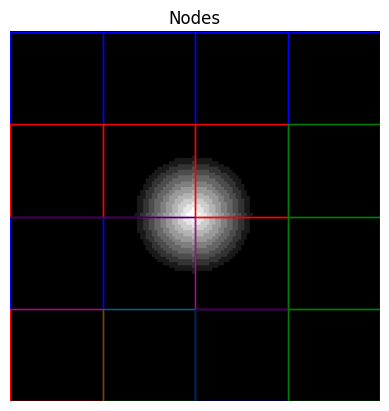

In [335]:
def display_nodes(img: np.ndarray, nodes: np.ndarray) -> None:
    """
    Display the nodes in the image

    :param img: image
    :param nodes: nodes
    """
    _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Nodes')

    for node in nodes:
        ax.add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    plt.show()

display_nodes(pic1, blocks)

In [347]:
def initialize_new_blocks(shape: tuple) -> np.ndarray:
    return np.zeros(shape)

def phi(pos: tuple[int, int], pos_min: tuple[int, int], pos_max: tuple[int, int]) -> list[float]:
    """
    Compute the phi functions (interpolation kernel)
    :param pos: position
    :param pos_min: minimum position
    :param pos_max: maximum position
    :return: phi functions (interpolation kernel)
    """
    x, y = pos
    
    x_min, y_min = pos_min
    x_max, y_max= pos_max

    cst = ((x_max - x_min) * (y_max - y_min))

    # Compute phi functions in regards to
    # the polynomials formulas
    phi_1 = (x_max - x) * (y_max - y) / cst
    phi_2 = (x - x_min) * (y_max - y) / cst
    phi_3 = (x_max - x) * (y - y_min) / cst
    phi_4 = (x - x_min) * (y - y_min) / cst

    return [phi_1, phi_2, phi_3, phi_4]

def displaced_frame_difference(d_b: np.ndarray, frame1: np.ndarray, frame2: np.ndarray, block_positions: np.ndarray) -> float:
    """
    Compute the displaced frame difference energy between two frames

    :param d: motion vector
    :param frame1: first frame
    :param frame2: second frame
    :param block: block
    :return: displaced frame difference
    """

    # Get the min and max positions of the blocks
    x_min, x_max = block_positions[:, 0].min(), block_positions[:, 0].max()
    y_min, y_max= block_positions[:, 1].min(), block_positions[:, 1].max()
   
    E_dfd: float = 0
    
    # Iterate over every pixel in the block
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            d = d_b.copy()
            # Compute the interpolation kernel
            phi_tup = phi((x, y), (x_min, y_min), (x_max, y_max))

            for k in range(d_b.shape[0]):
                d += phi_tup[k] * d_b[k]
            
            d = d.sum(axis=0)
            # Compute the new position
            new_pos = np.array([x, y]) + d.astype(int)
            new_pos = np.clip(new_pos, 0, frame1.shape[0] - 1)
            
            # Compute the displaced frame difference
            E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y])

    return E_dfd

def get_displaced_block(frame1: np.ndarray, frame2: np.ndarray, block: np.ndarray, d: np.ndarray, learning_rate: float) -> np.ndarray:
    """
    Compute the displaced blocks
    :param frame1: first frame
    :param frame2: second frame
    :param blocks: blocks
    :param d: motion vector
    :return: displaced blocks
    """
    for _ in range(10):
        E_dfd = displaced_frame_difference(d, frame1, frame2, block)

        gradient = np.zeros((4, 2))
        for i in range(gradient.shape[0]):
            for j in range(gradient.shape[1]):
                diff_d = d.copy()
                diff_d[i, j] += 1
                diff_E_dfd = displaced_frame_difference(diff_d, frame1, frame2, block)
                gradient[i, j] = (diff_E_dfd - E_dfd)

        d = d - learning_rate * gradient

        if np.abs(gradient).mean() * learning_rate < 0.1:
            break
        
    return d

/var/folders/6w/l_4p050n0js7pwx4t7cb7k5r0000gn/T/ipykernel_53062/925793972.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
  E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y]) ** 2


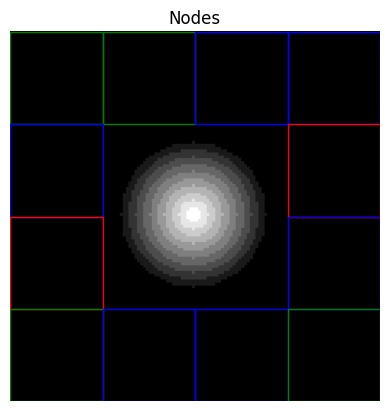

In [348]:
d_new = initialize_new_blocks((blocks.shape))
for i in range(blocks.shape[0]):
    d_new[i] = get_displaced_block(pic1, pic2, blocks[i], d_new[i], LEARNING_RATE)
new_blocks = blocks + d_new
display_nodes(pic2, new_blocks)